### Library Imports

In [2]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

### Todo:

Do inter-event time analysis at the minute level. Fit distribution and measure mean + kurtosis (and I mean spread too while I'm at it). Look at this over T

See if its exponential- log-Y scale plot of interevent times
Or does the tail decay?

### Data Imports

In [3]:
lookup = pd.read_csv('days_weeks_lookup.csv')
week_lookup = {lookup['Date'].tolist()[i]: lookup['week_ID'].tolist()[i] for i in range(len(lookup))}

data = pd.DataFrame()
for i in ['UKc', 'UKt', 'USc', 'USt']:
    temp_df = pd.read_csv(f'/Users/jericho/Documents/csi/ts_phonecalls/data/{i}.txt',sep='\t')
    temp_df['Source'] = [i]*len(temp_df)
    data = pd.concat([data,temp_df],axis=0)

#print(type(data['time'].tolist()[0]))
data['time'] = pd.to_datetime(data['time'], infer_datetime_format=True)
data['date'] = pd.to_datetime(data['date'], infer_datetime_format=True)
#print(type(data['time'].tolist()[0]))
#print(data.shape)
#data.head() 

### Ego-Alter pair datasets

In [4]:
pairs = data['pair'].unique().tolist()
pair_datasets = {}
for p in pairs:
    temp_df = data[data['pair']==p]
    time_range = temp_df['time'].max() - temp_df['time'].min()
    temp_df = temp_df[temp_df['Source'].isin(['UKc','USc','ITc'])]
    if time_range.days > 89:
        pair_datasets[p] = temp_df


### Analysis of phonecall Time Series data

$P(\tau)= \lambda * exp(-\lambda * \tau)$, where $\lambda = 1/$ characteristic time between calls<br>
make $\lambda$ a function of time $t$ where $t$ is a clock over a week<br>
$\lambda_{ix}(t)$ (edited) <br>
$P_{ix}(\tau)= \lambda_{ix}(t) * exp(-\lambda_{ix}(t) * \tau)$ <br>

Parameterization:<br>
 - characteristic time between calls??<br>
 - $\lambda = 1/$ characteristic time between calls<br>
 - $t$ = a clock over a week

In [5]:
def p_tau_func(lambda_var, tau_var):
    p_tau = lambda_var * math.exp(-lambda_var * tau_var)
    return p_tau

In [6]:
def get_lambdas(pd_series):
    t_hours = [i.hour for i in pd_series.tolist()]
    t_hours_count = dict()
    for i in t_hours:
        t_hours_count[i] = t_hours_count.get(i,0)+1
    for k,v in t_hours_count.items():
        t_hours_count[k] = v/len(t_hours)
    return t_hours_count

In [7]:
def get_list_lambdas(t_hours):
    t_hours_count = dict()
    for i in t_hours:
        t_hours_count[i] = t_hours_count.get(i,0)+1
    for k,v in t_hours_count.items():
        t_hours_count[k] = v/len(t_hours)
    return t_hours_count

<BarContainer object of 14 artists>

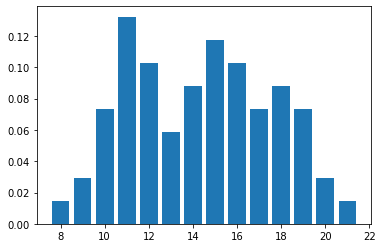

In [8]:
t = pair_datasets['-0x14ea2a5a00156840']
t = t[t['Source'].isin(['UKc','USc','ITc'])]
t_hours_count = get_lambdas(t['time'])
plt.bar(t_hours_count.keys(), t_hours_count.values())

In [9]:
t_times = t['time'].tolist()
t_days = [i.day for i in t_times]
t_months = [i.month for i in t_times]
t_years = [i.year for i in t_times]
t_hours = [i.hour for i in t_times]
t_dates = [f'{t_months[i]}/{t_days[i]}/{t_years[i]}' for i in range(len(t_days))]
t_weeks = [week_lookup[i] for i in t_dates]
print(len(t_times))

68


In [10]:
t_interevent_timedelta = [t_times[i]-t_times[i-1] for i in range(1,len(t_times))]
t_interevent = [i.days*24 + i.seconds/3600 for i in t_interevent_timedelta]

p_taus = []
for i in range(1,len(t_times)):
    lambda_var = t_hours_count[t_hours[i]]
    tau_var = t_interevent[i-1]
    p_taus.append(p_tau_func(lambda_var, tau_var))

In [11]:
p_tau_func(0.085, 26.5)

0.008936564725892115

Take a distribution, $\phi(t_1,t_2)$, where $t_1 < t_2$

It is given by:

$\phi(t_1,t_2)=\lambda(t_2) \times \exp[-\sum_{t=t_1}^{t_2} \lambda(t) ]$.

Now, say that the times in which an ego-alter pair interacted where given by the list:

$T=\{t_1, t_2, t_3, ..., t_n\}$
where $n$ is the number of interactions. 

Then, their entire time series has the probability

$\Phi(T)=[\prod_{i=2}^n \lambda(t_i) ] \times \exp[ - \sum_{t_1}^{t_n} \lambda(t) ]$

Note that this is $\Phi$ (capital) rather than $\phi$ (lower case).

I'm still thinking through the statistical testing. Time series analysis is more focused on forecasting and other sorts of questions, but the idea here is a bit different where something like a p-value is not a bad test. The difficulty for a p-value test is that $\Phi(T)$ takes in $T$ (time series), which may mean that the test requires Monte Carlo.

### A Simpler Goodness of Fit

68


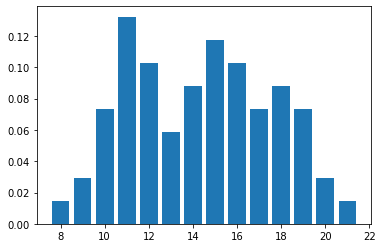

In [12]:
t = pair_datasets['-0x14ea2a5a00156840']
t = t[t['Source'].isin(['UKc','USc','ITc'])]
t_hours_count = get_lambdas(t['time'])
plt.bar(t_hours_count.keys(), t_hours_count.values())

t_times = t['time'].tolist()
t_days = [i.day for i in t_times]
t_months = [i.month for i in t_times]
t_years = [i.year for i in t_times]
t_hours = [i.hour for i in t_times]
t_dates = [f'{t_months[i]}/{t_days[i]}/{t_years[i]}' for i in range(len(t_days))]
t_weeks = [week_lookup[i] for i in t_dates]
print(len(t_times))

In [13]:
def measure_daily_error(lambdas, hours):
    hour_lambdas = get_list_lambdas(hours)
    sse = 0
    for k,v in hour_lambdas.items():
        sse += (v-lambdas[k])**2
    for k,v in lambdas.items():
        if k not in hour_lambdas:
            sse += v**2
    return sse

In [14]:
def linear_regression(X,y):
    X = [[i] for i in X]
    X = np.array(X)
    reg = LinearRegression().fit(X,y)
    return reg.coef_

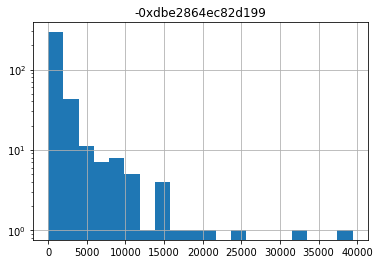

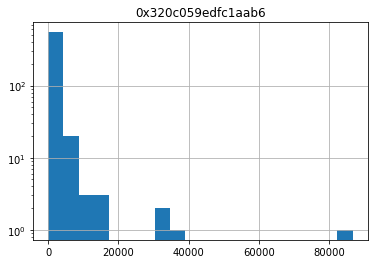

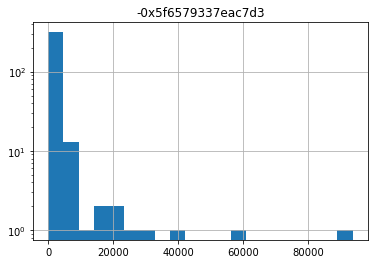

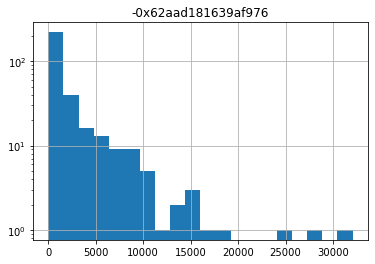

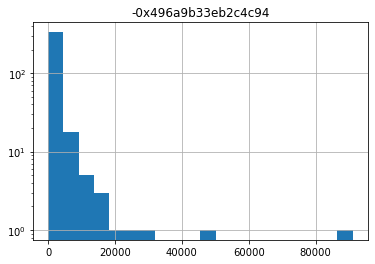

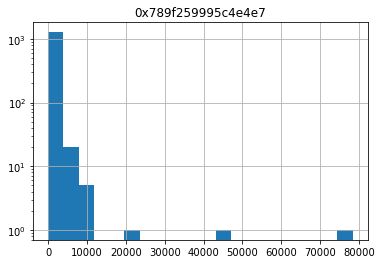

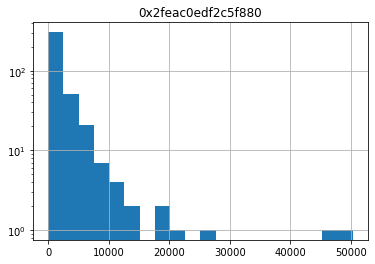

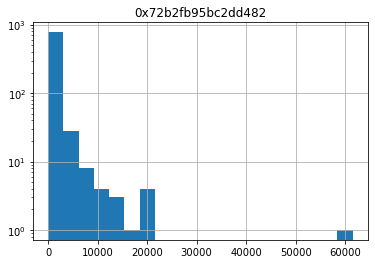

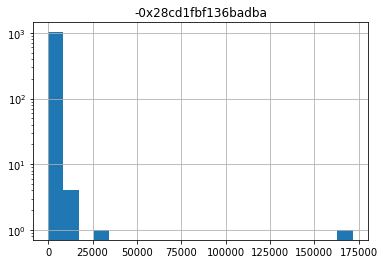

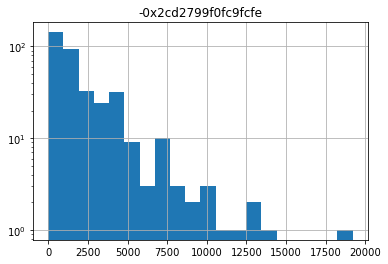

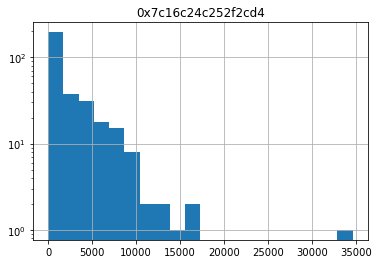

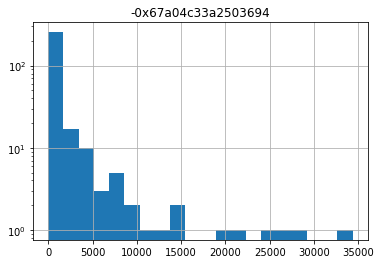

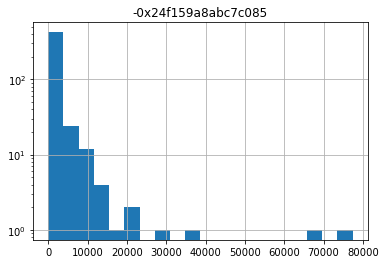

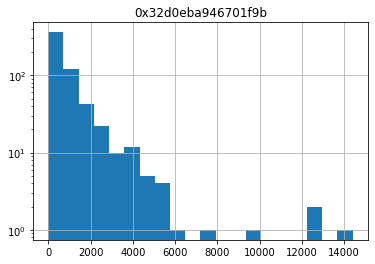

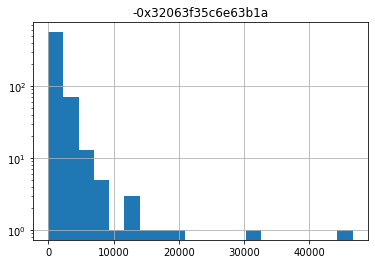

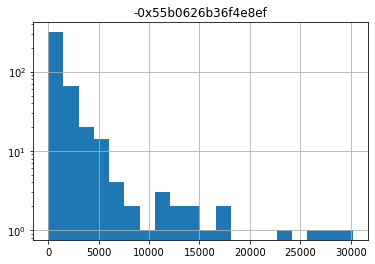

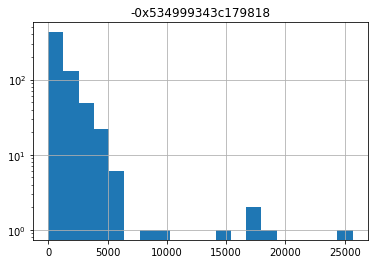

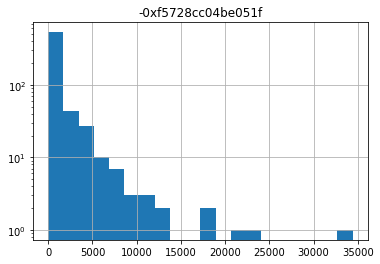

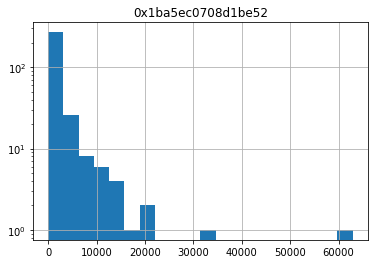

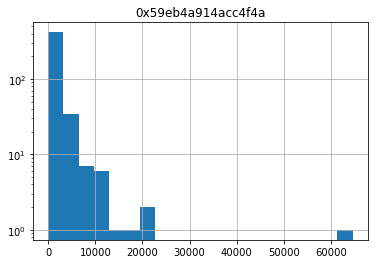

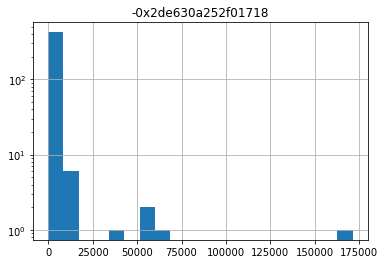

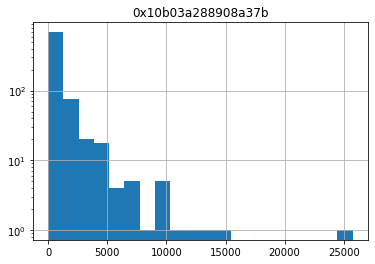

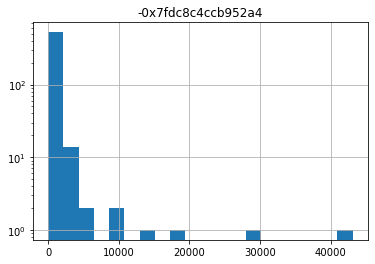

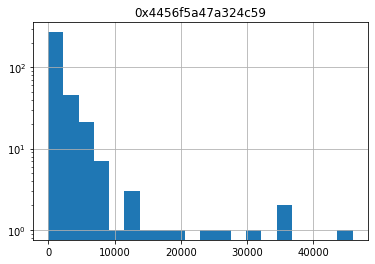

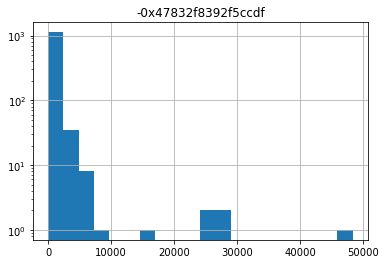

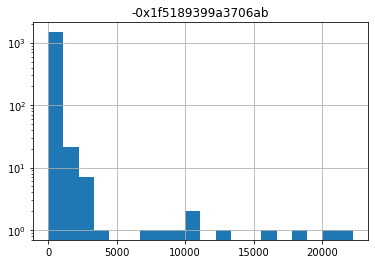

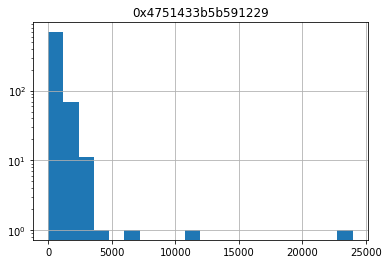

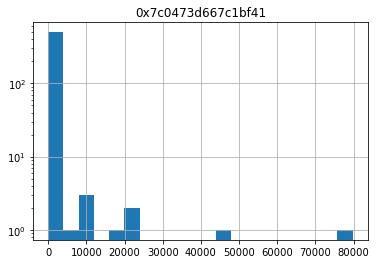

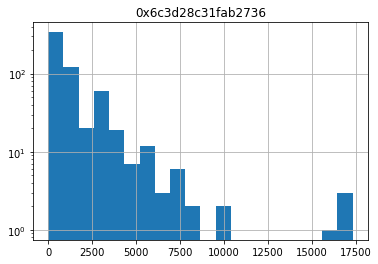

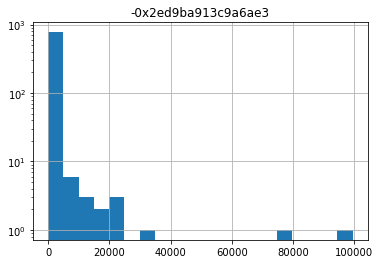

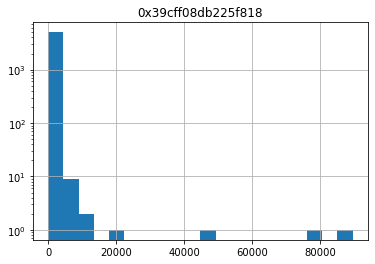

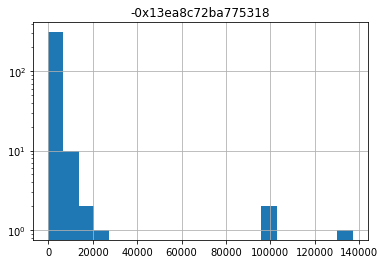

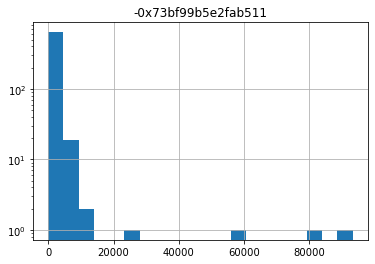

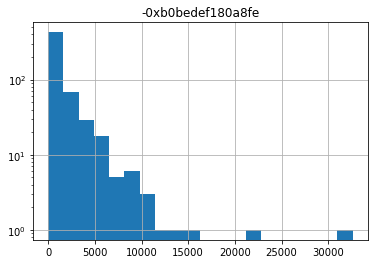

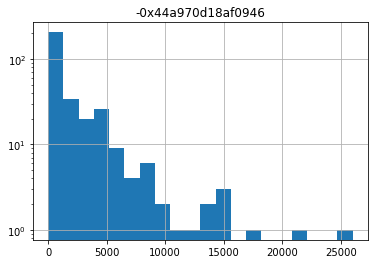

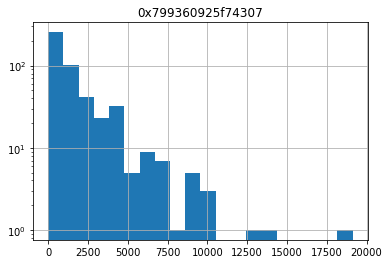

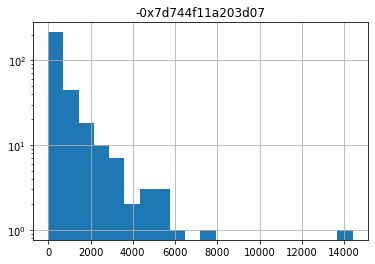

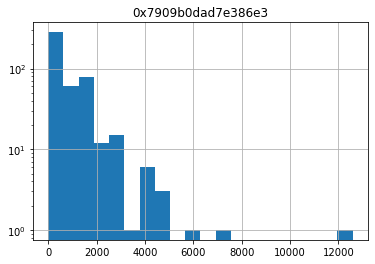

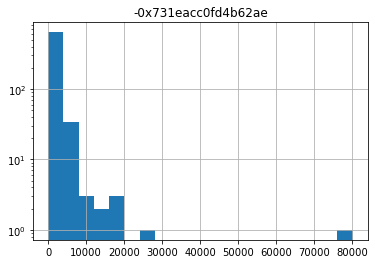

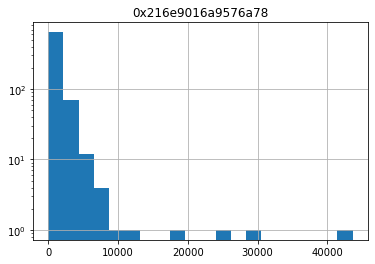

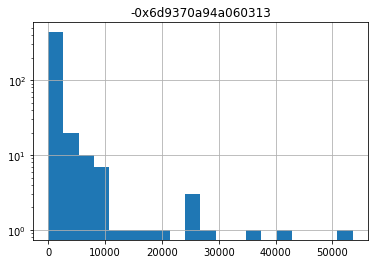

In [22]:
for k,t in pair_datasets.items():
    #temp_df = pair_datasets['-0x14ea2a5a00156840']
    if len(t) > 300:
        temp_df = t
        temp_df = temp_df[temp_df['Source'].isin(['UKc','USc','ITc'])]
        times = temp_df.time.tolist()
        times = [times[0]]+times[:-1]
        temp_df['time2'] = times
        temp_df['time_diff'] = (temp_df['time'] - temp_df['time2']) / np.timedelta64(1,'m')
        temp_df['time_diff'].hist(bins=20)
        plt.yscale('log')
        plt.title(k)
        plt.show()


#### Weekly Sums

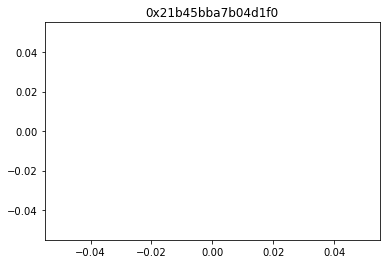

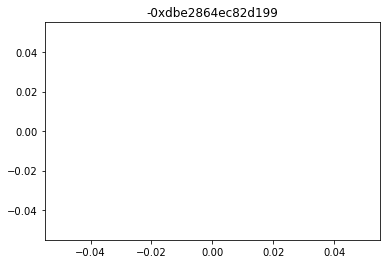

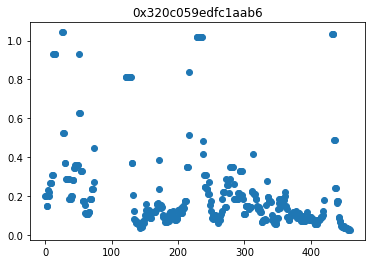

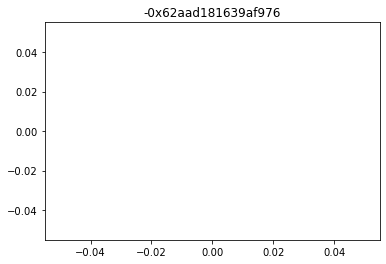

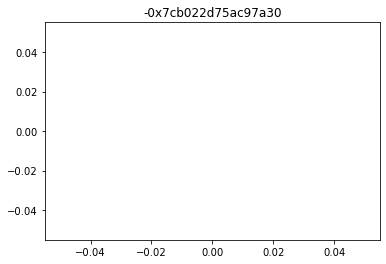

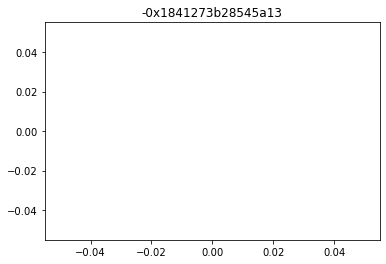

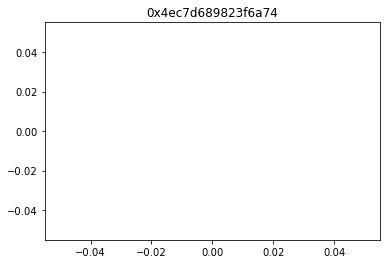

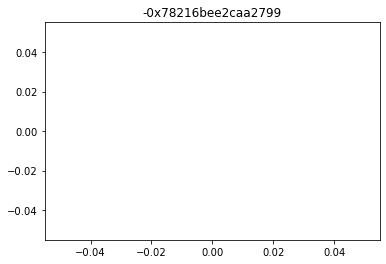

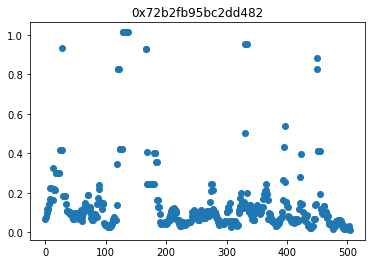

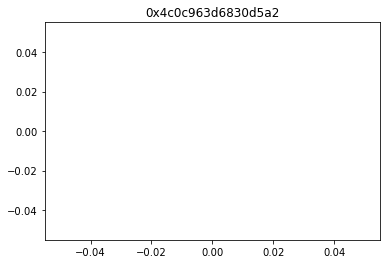

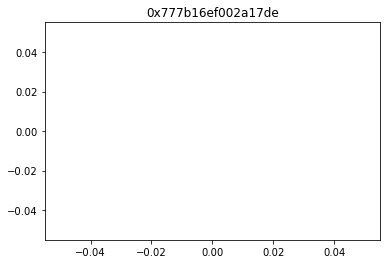

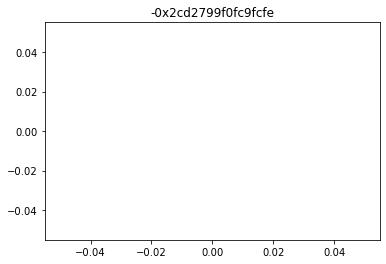

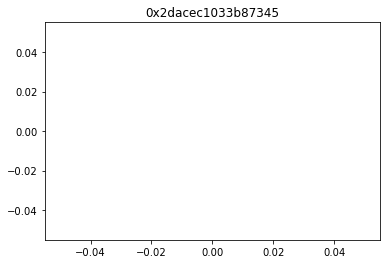

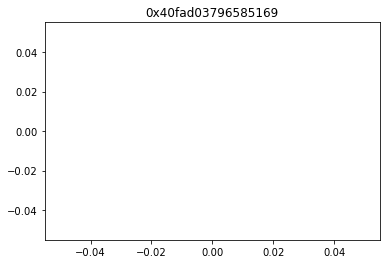

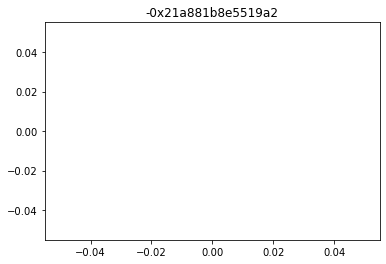

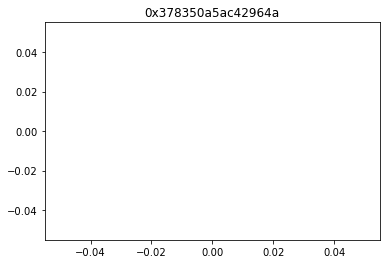

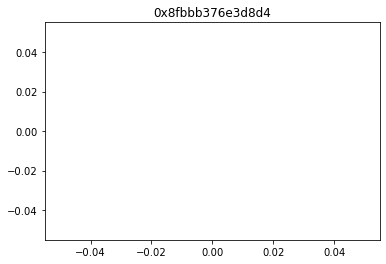

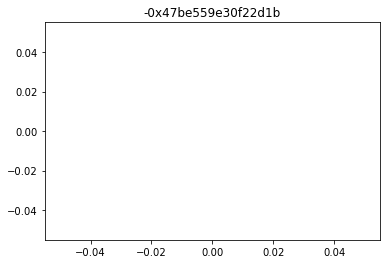

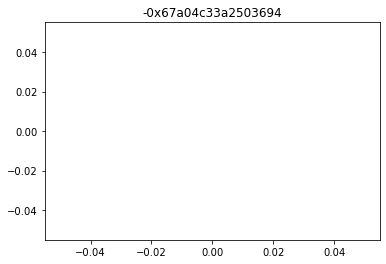

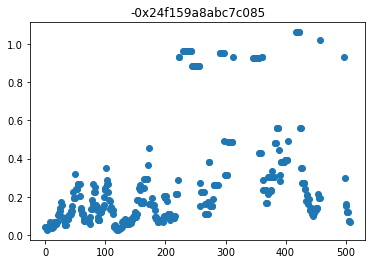

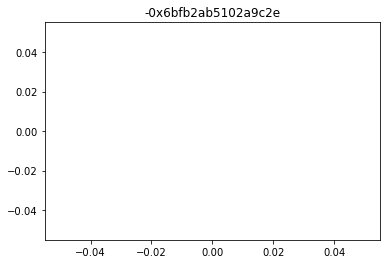

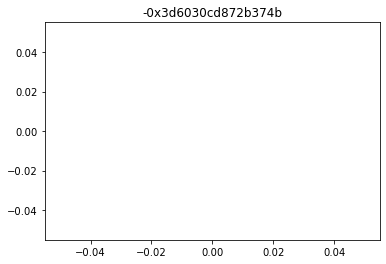

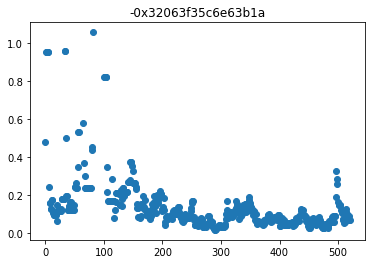

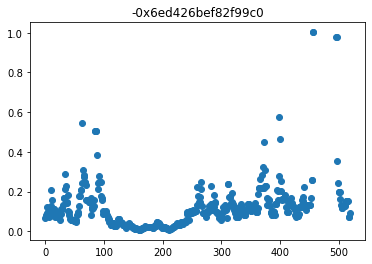

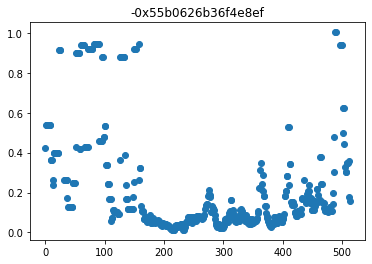

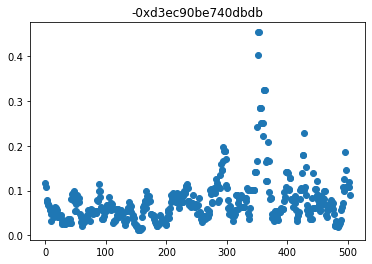

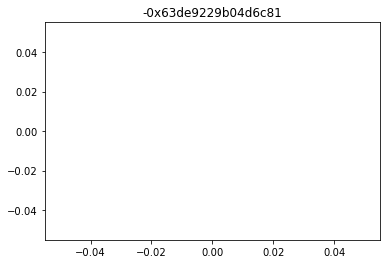

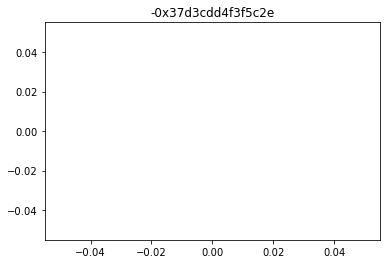

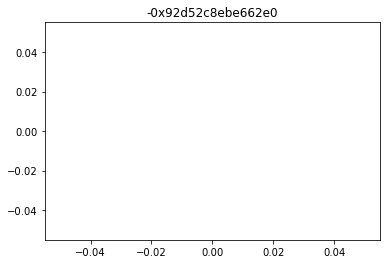

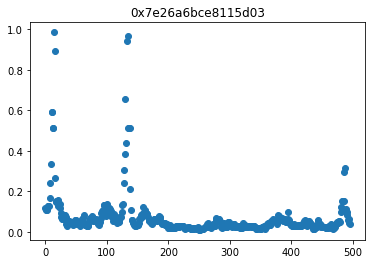

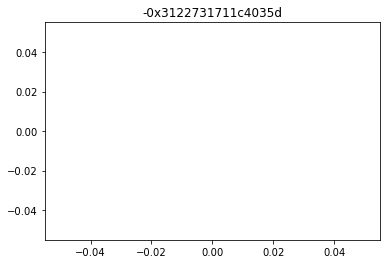

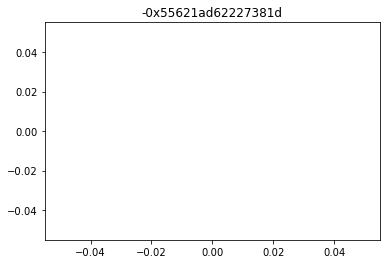

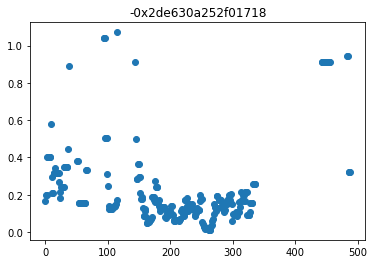

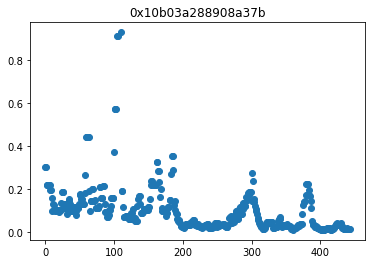

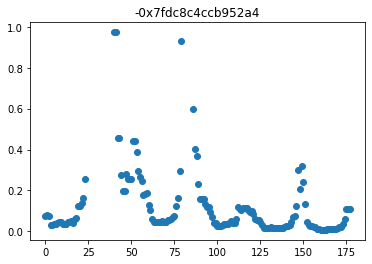

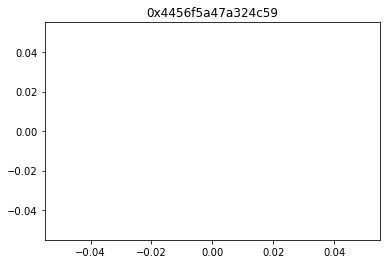

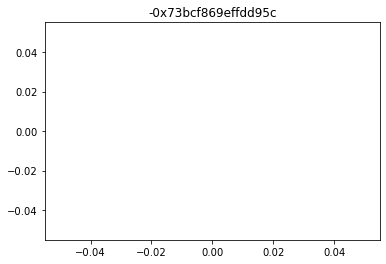

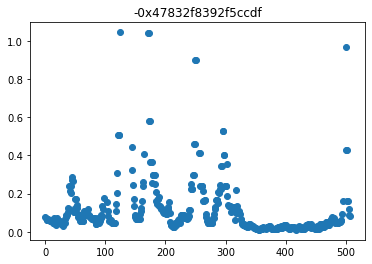

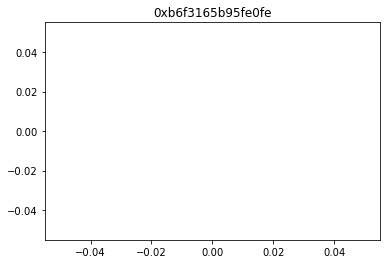

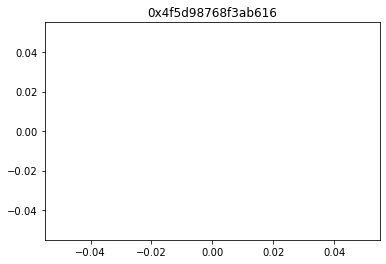

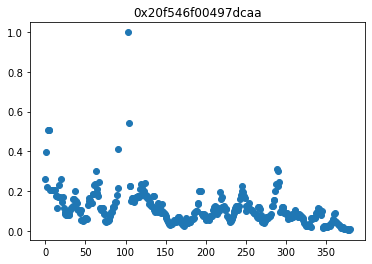

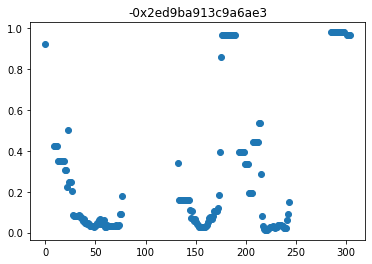

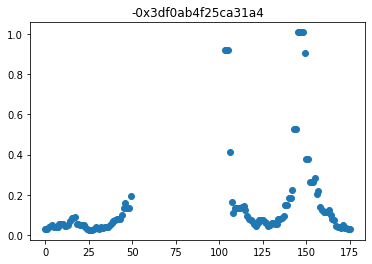

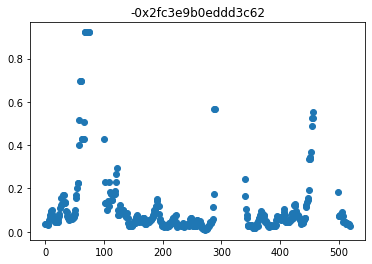

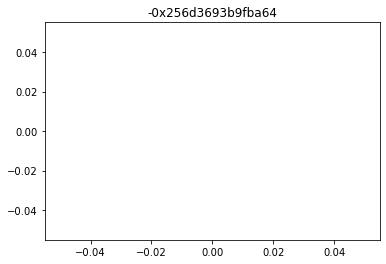

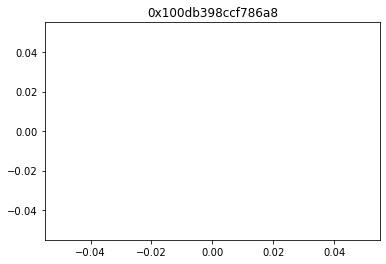

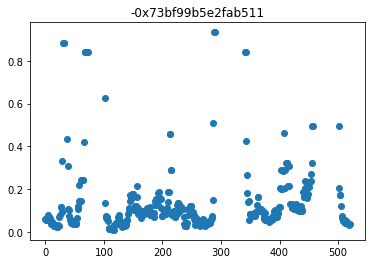

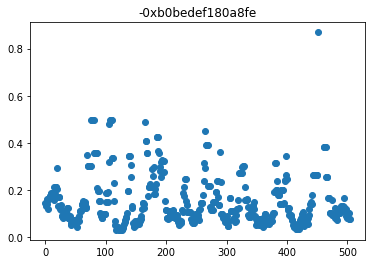

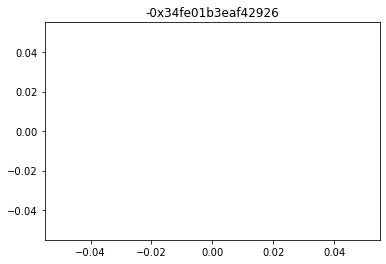

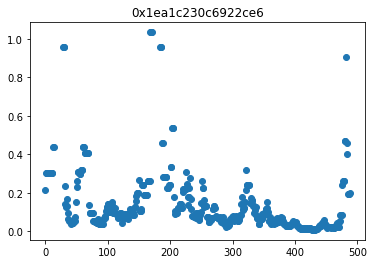

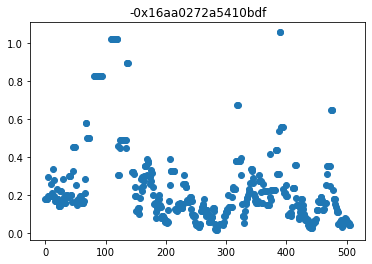

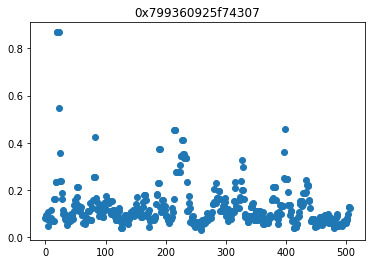

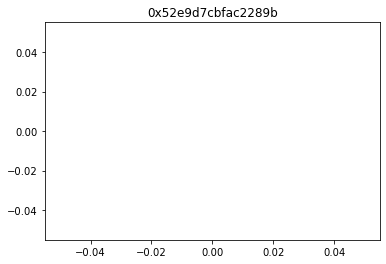

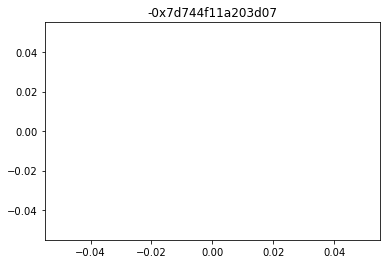

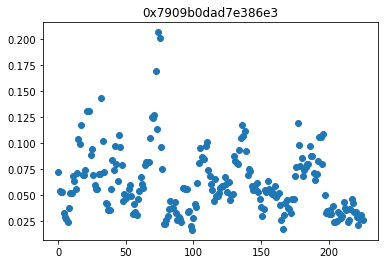

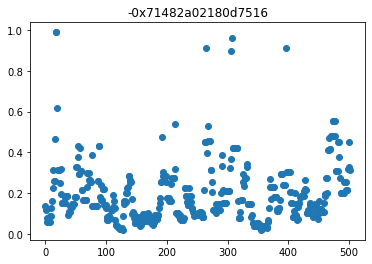

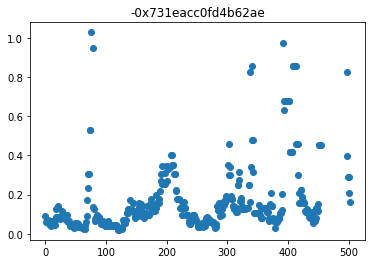

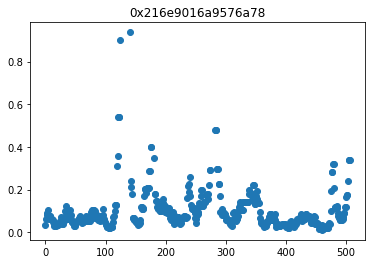

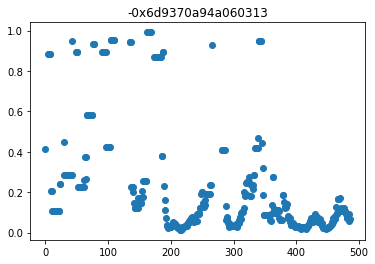

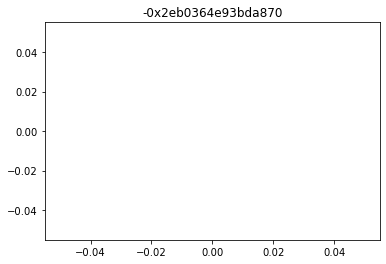

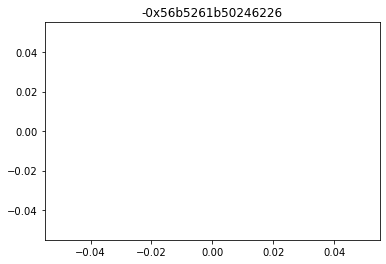

In [18]:
slopes = []

for k,t in pair_datasets.items():
    if len(t) > 200:
        #print(k)

        #t = pair_datasets['-0x14ea2a5a00156840']
        t = t[t['Source'].isin(['UKc','USc','ITc'])]
        t_hours_count = get_lambdas(t['time'])
        t_times = t['time'].tolist()
        t_days = [i.day for i in t_times]
        t_months = [i.month for i in t_times]
        t_years = [i.year for i in t_times]
        t_hours = [i.hour for i in t_times]
        t_dates = [f'{t_years[i]}-{t_months[i]}-{t_days[i]}' for i in range(len(t_days))]
        t_all_dates = pd.date_range(start=t_dates[0],end=t_dates[-1])
        t_all_dates = t_all_dates.strftime('%Y-%-m-%-d')
        df = pd.DataFrame(data={'Times':t_times, 'Hour':t_hours, 'Date':t_dates})
        sses = []
        null = 0
        if len(df) > 400:
            date_list = t_all_dates.tolist()
            for date_idx in range(14,len(date_list)):
                date_temp_list = date_list[date_idx-14:date_idx]
                #print(date_temp_list)
                temp_df = df[df['Date'].isin(date_temp_list)]
                hours = temp_df.Hour.tolist()
                sse = measure_daily_error(t_hours_count, hours)
                sses.append(sse)
                if len(temp_df) == 0 and null == 0:
                    null = sse

        x = [i for i in range(len(sses)) if sses[i]!=null]
        y = [i for i in sses if i!=null]
        #first90perc = int(len(x)*0.9)
        #x = x[:first90perc]
        #y = y[:first90perc]
        #reg = linear_regression(x,y)
        #slopes.append(reg)

        #print(reg)
        plt.scatter(x,y)
        #plt.plot([x[0],x[-1]], [null,null])
        plt.title(k)
        plt.show()


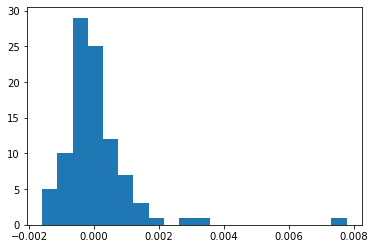

0.4105263157894737


In [ ]:
slopes_clean = [i[0] for i in slopes]
plt.hist(slopes_clean,bins=20)
plt.show()

positives= [1 if i>0 else 0 for i in slopes_clean]
print(sum(positives)/len(positives))

#### Daily Sums

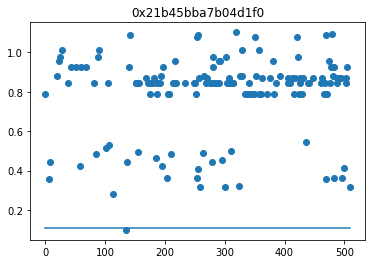

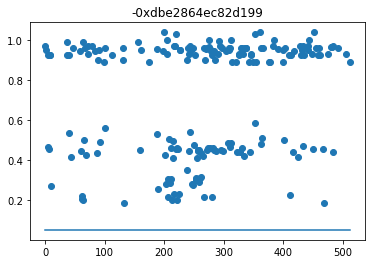

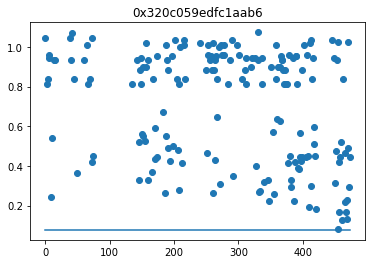

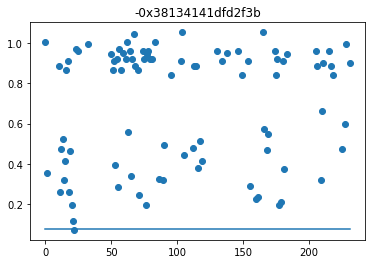

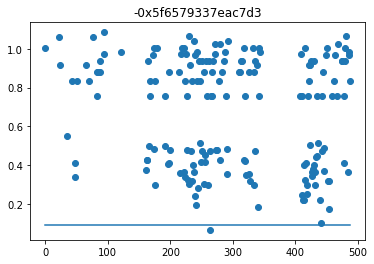

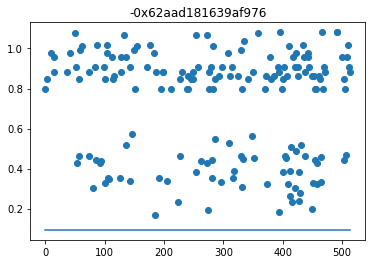

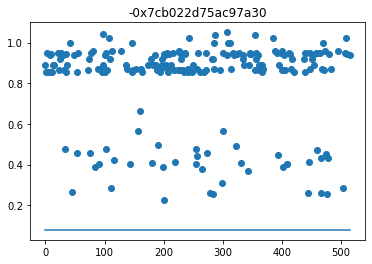

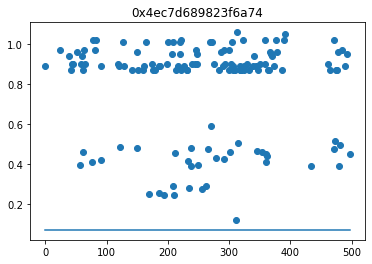

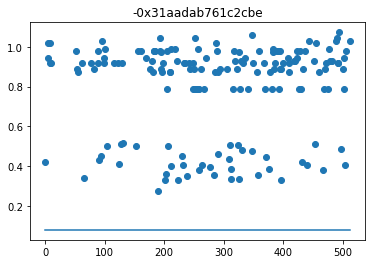

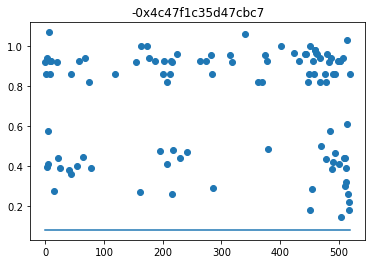

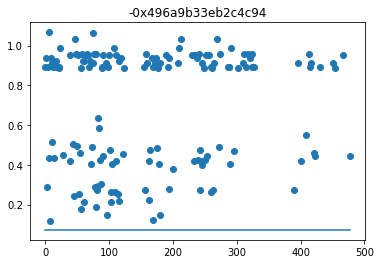

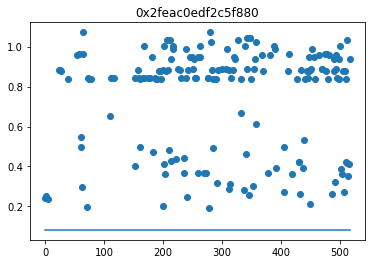

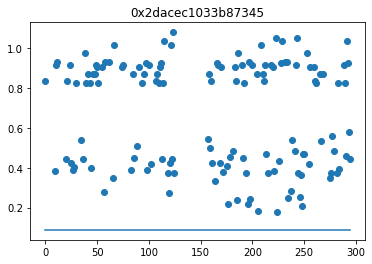

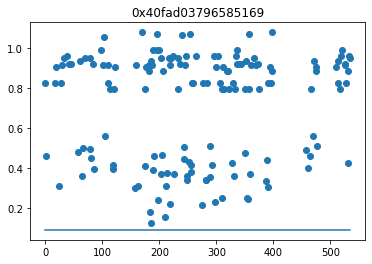

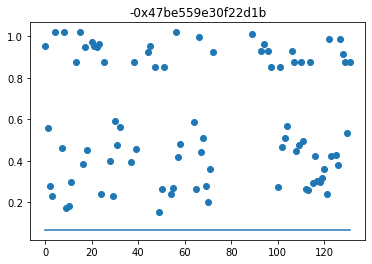

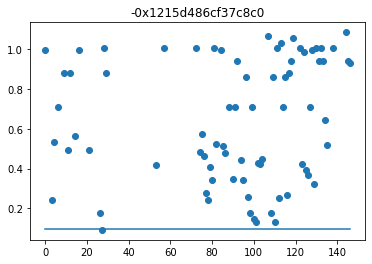

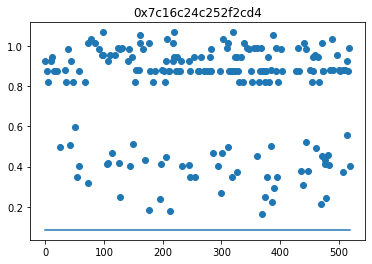

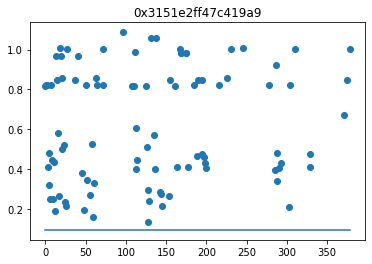

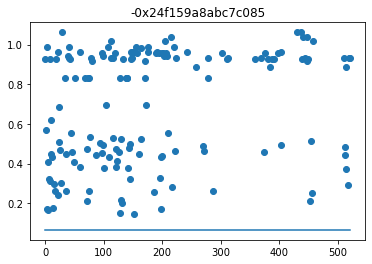

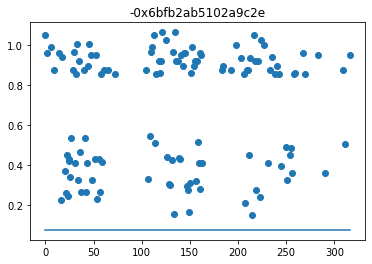

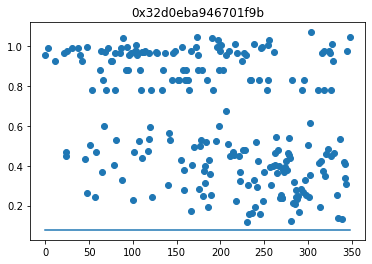

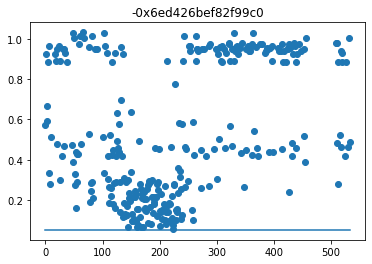

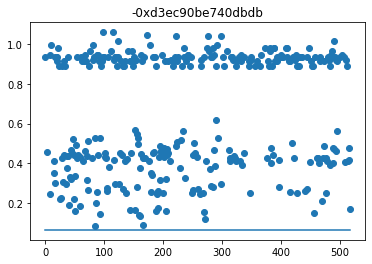

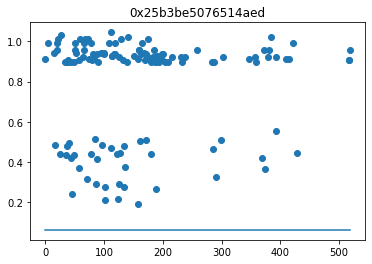

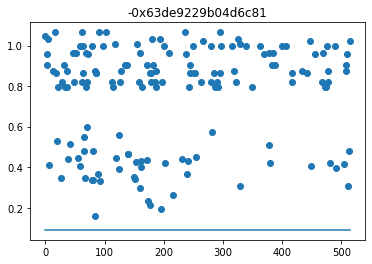

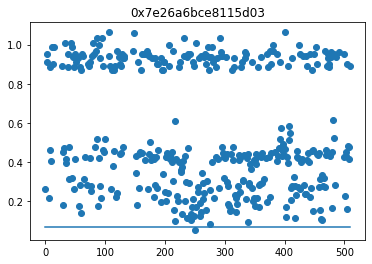

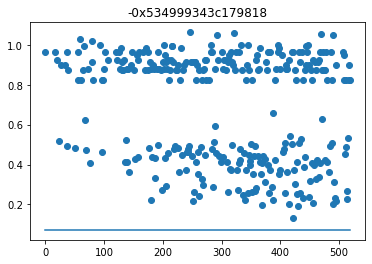

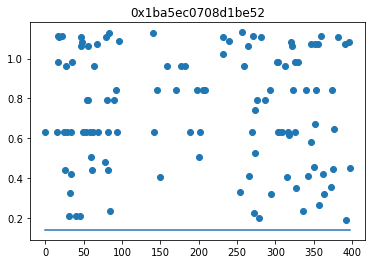

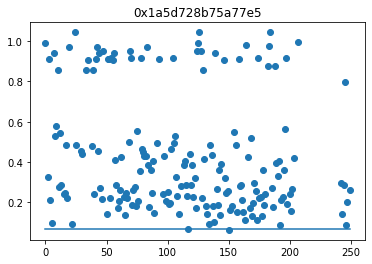

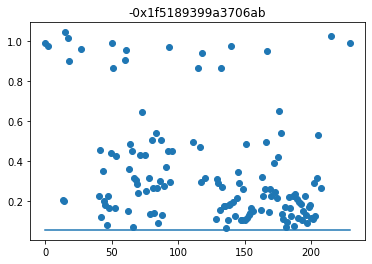

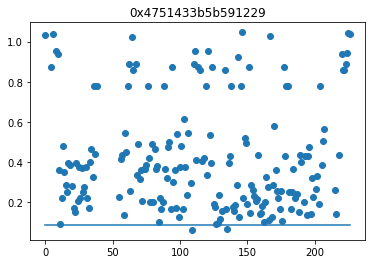

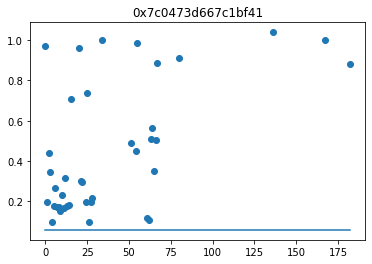

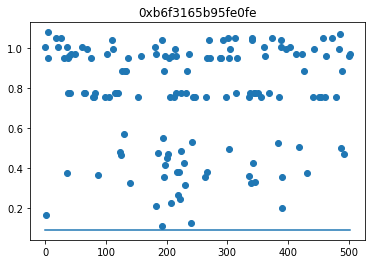

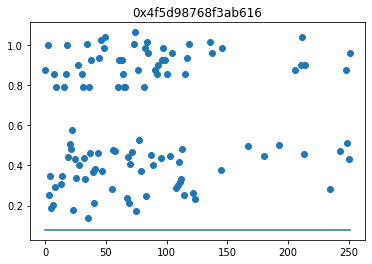

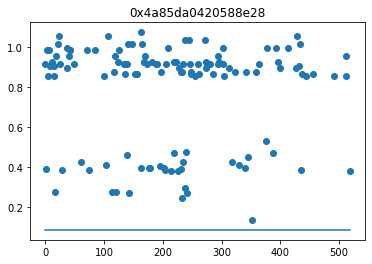

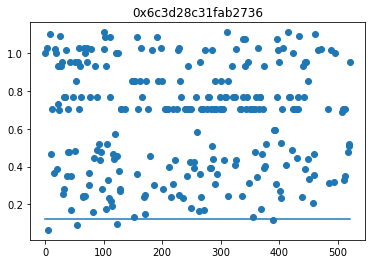

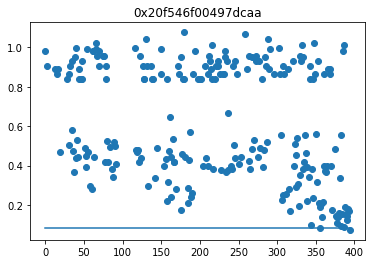

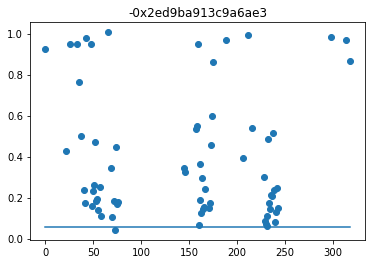

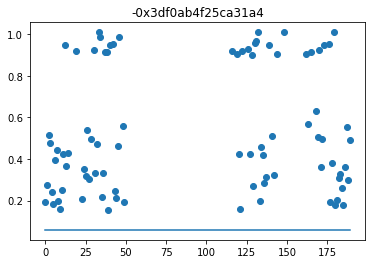

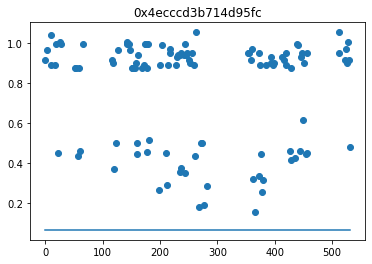

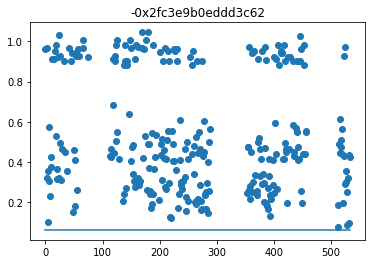

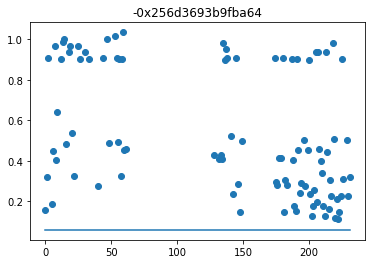

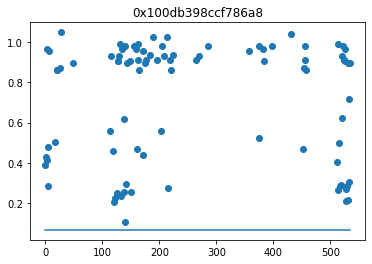

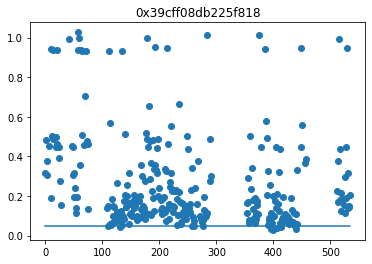

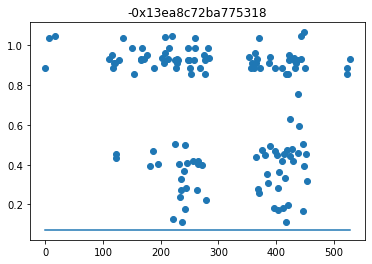

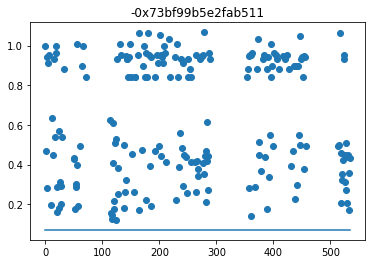

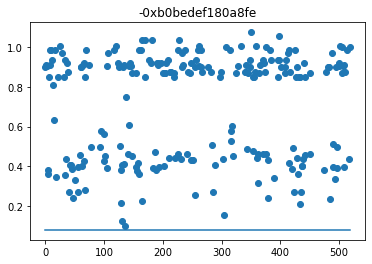

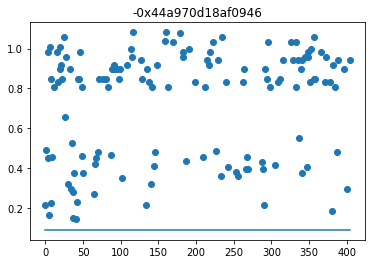

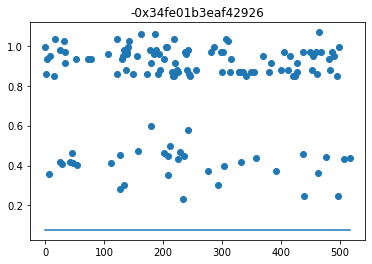

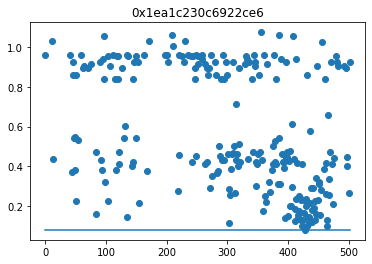

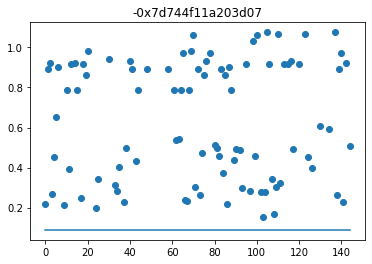

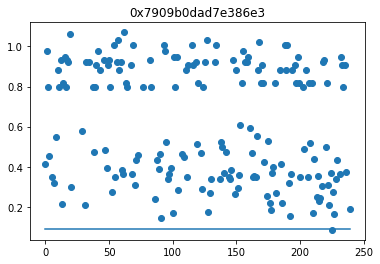

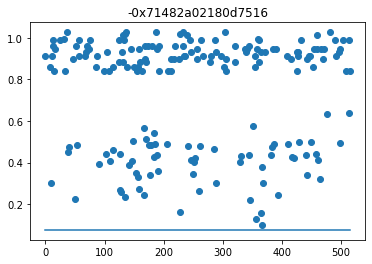

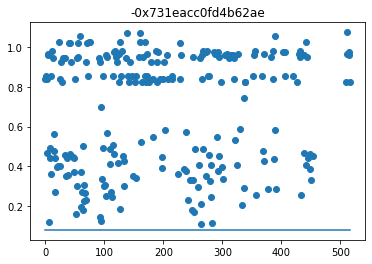

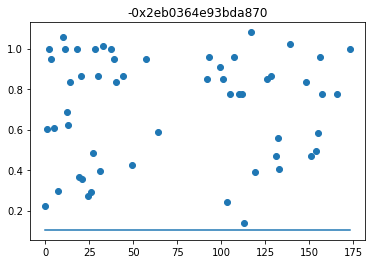

In [ ]:
for k,t in pair_datasets.items():
    if len(t) > 200:
        #print(k)

        #t = pair_datasets['-0x14ea2a5a00156840']
        t = t[t['Source'].isin(['UKc','USc','ITc'])]
        t_hours_count = get_lambdas(t['time'])
        t_times = t['time'].tolist()
        t_days = [i.day for i in t_times]
        t_months = [i.month for i in t_times]
        t_years = [i.year for i in t_times]
        t_hours = [i.hour for i in t_times]
        t_dates = [f'{t_years[i]}-{t_months[i]}-{t_days[i]}' for i in range(len(t_days))]
        t_all_dates = pd.date_range(start=t_dates[0],end=t_dates[-1])
        t_all_dates = t_all_dates.strftime('%Y-%-m-%-d')
        df = pd.DataFrame(data={'Times':t_times, 'Hour':t_hours, 'Date':t_dates})
        sses = []
        null = 0
        if len(df) > 400:
            date_list = t_all_dates.tolist()
            for date in date_list:
                date_temp_list = date_list
                temp_df = df[df['Date']==date]
                hours = temp_df.Hour.tolist()
                sse = measure_daily_error(t_hours_count, hours)
                sses.append(sse)
                if len(temp_df) == 0 and null == 0:
                    null = sse

        x = [i for i in range(len(sses)) if sses[i]!=null]
        y = [i for i in sses if i!=null]
        plt.scatter(x,y)
        plt.plot([x[0],x[-1]], [null,null])
        plt.title(k)
        plt.show()
